In [1]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.lines as mlines
import datetime
import pandas as pd
import numpy as np
import math
import os
from scipy.optimize import brentq
from sklearn.neighbors.kde import KernelDensity
import xarray as xr

from filterpy.kalman import UnscentedKalmanFilter as UKF
from filterpy.kalman import KalmanFilter as KF
from filterpy.kalman import MerweScaledSigmaPoints
from filterpy.common import Q_continuous_white_noise

import progressbar

import clemb
from clemb.forward_model import Forwardmodel
from clemb.data import LakeData
from clemb.syn_model import SynModel
from clemb.uks import UnscentedKalmanSmoother

/usr/local/anaconda3/envs/pumahu/lib/python3.6/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.neighbors.kde module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


## Overview plot

/usr/local/anaconda3/envs/pumahu/lib/python3.6/site-packages/cartopy/io/img_tiles.py:320: UserWarning: The StamenTerrain class was deprecated in v0.17. Please use Stamen('terrain-background') instead.
  "The StamenTerrain class was deprecated in v0.17. "


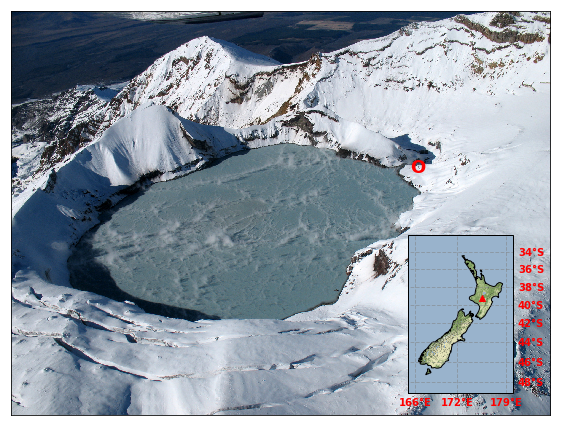

In [2]:
import cartopy.crs as ccrs
from cartopy.io.img_tiles import StamenTerrain
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker

fn = '6277_RCL_Karen_Britten_GNS_Science.jpg'
arr_img = plt.imread(fn, format='jpg')
y, x, z = arr_img.shape
factor=300
fig = plt.figure(figsize=(x/factor, y/factor))
ax1 = fig.add_axes([0.05, 0.05, 0.9, 0.9])
ax1.imshow(arr_img)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.text(1850,750, 'O', color='red', weight='bold', size='18')

# Map
tiler = StamenTerrain()
mercator = tiler.crs
ax2 = fig.add_axes([0.65,0.1,0.3,0.35], projection=mercator)
ax2.set_extent([165, 180, -49, -32], crs=ccrs.PlateCarree())
ax2.add_image(tiler, 6)
ax2.coastlines(resolution='50m')

gl = ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_left = False
gl.xlines = True
gl.ylines = True
gl.xlocator = mticker.FixedLocator([160, 166, 172, 179, 180])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'color': 'red', 'weight': 'bold', 'size':10}
gl.ylabel_style = {'color': 'red', 'weight': 'bold', 'size':10}
ax2.plot(175.564490, -39.281149, marker='^', color='red',
         markersize=6, transform=ccrs.PlateCarree())
fig.savefig('overview.png', dpi=300, bbox_inches='tight')

In [3]:
def density_plot(ax, rs, prm, prm_lim=(0, 1600, 1000),  bw=60., mode='kde'):
    nsteps = rs.dims['dates']
    if mode == 'kde':
        m = []
        for i in range(nsteps):
            y = rs[prm][i].data
            idx = np.isnan(y)
            _kde = KernelDensity(kernel='gaussian', bandwidth=bw).fit(y[~idx].reshape(-1,1))
            X_plot = np.linspace(*prm_lim)
            log_dens = _kde.score_samples(X_plot[:, np.newaxis])
            m.append(np.exp(log_dens))
        m = np.array(m)
        ax.contourf(np.arange(nsteps), X_plot,  m.T, 30, cmap=plt.cm.get_cmap('RdBu_r'))
    if mode == 'scatter':
        datet = rs['dates']
        nresample = rs[prm].shape[1]
        for k in range(nsteps):
            ax.scatter([datet[k].data]*nresample, rs[prm][k], s=2, c=rs['lh'][k],
                    cmap=plt.cm.get_cmap('RdBu_r'), alpha=0.3)
    return

def adjust_labels(ax, dates, rotation=30, fontsize=10):
    new_labels = []
    new_ticks = []
    for _xt in ax.get_xticks():
        try:
            dt = dates[int(_xt)].astype('datetime64[us]').min()
            new_labels.append((pd.to_datetime(str(dt))
                                .strftime("%Y-%m-%d")))
            new_ticks.append(_xt)
        except IndexError:
            continue
    ax.set_xticks(new_ticks)
    ax.set_xticklabels(new_labels, rotation=rotation, horizontalalignment='right', fontsize=fontsize)


## Synthetic test

In [3]:
xds = SynModel(seed=42).run(1000., nsteps=100, integration_method='rk4', 
                    gradient=True, mode='gamma+sin', addnoise=True,
                    estimatenoise=False)

In [4]:
np.random.seed(55)
gap_idx = np.random.randint(0,xds['Mo'].size,int(0.2*xds['Mo'].size))
a = np.arange(0,100,5)
b = np.arange(100)
gap_idx = np.setdiff1d(b,a)
xds['Mo'][gap_idx] = np.nan
xds['Mo_err'][gap_idx] = np.nan
xds['X'][gap_idx] = np.nan
xds['X_err'][gap_idx] = np.nan
xds['W_err'] *= 1e-10

In [5]:
data = xds.to_dataframe()
var_names = ['T', 'M', 'X', 'qi', 'Mi',
             'Mo', 'H', 'W', 'dqi',
             'dMi', 'dMo', 'dH', 'dW']
nvars = len(var_names)

X0 = xr.DataArray(np.ones(nvars)*np.nan, dims=('x'), coords={'x': var_names})
for k in var_names[:8]:
    X0.loc[k] = data.iloc[0][k]
X0.loc['dqi'] = 1e-1
X0.loc['dMi'] = 1e-1
X0.loc['dMo'] = 1e-1
X0.loc['dW'] = 0
X0.loc['dH'] = 0
X0.loc['qi'] *= 0.0864

Q = xr.DataArray(np.eye(nvars, nvars), dims=('x', 'y'),
                 coords={'x': var_names, 'y': var_names})
Q.loc['T','T'] = 1e-3
Q.loc['M','M'] = 1e-3
Q.loc['X','X'] = 1e-3
Q.loc['qi','qi'] = 1e-1
Q.loc['Mi','Mi'] = 1e0
Q.loc['Mo','Mo'] = 1e0
Q.loc['W','W'] = 1e-10
Q.loc['H','H'] = 1e-10
Q.loc['dqi','dqi'] = 1e3
Q.loc['dMi','dMi'] = 1e1
Q.loc['dMo','dMo'] = 1e1
Q.loc['dW','dW'] = 1e-10
Q.loc['dH','dH'] = 1e-10

P0 = xr.DataArray(np.eye(nvars, nvars), dims=('x', 'y'),
                 coords={'x': var_names, 'y': var_names})
P0.loc['T','T'] = .1*X0.loc['T']
P0.loc['M','M'] = .1*X0.loc['M']
P0.loc['X','X'] = .5*X0.loc['X']
P0.loc['qi','qi'] = 100*0.0864
P0.loc['Mi','Mi'] = 1e2
P0.loc['Mo','Mo'] = 1e2
P0.loc['W','W'] = 1e-3
P0.loc['H','H'] = 1e-3
P0.loc['dqi','dqi'] = 1
P0.loc['dMi','dMi'] = 1
P0.loc['dMo','dMo'] = 1
P0.loc['dW','dW'] = 1e-3
P0.loc['dH','dH'] = 1e-3

In [6]:
uks = UnscentedKalmanSmoother(data=xds.to_dataframe())
log_lh = uks(Q, X0, P0, test=True)
print(log_lh)

-1733.3041398765715


/usr/local/anaconda3/envs/pumahu/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


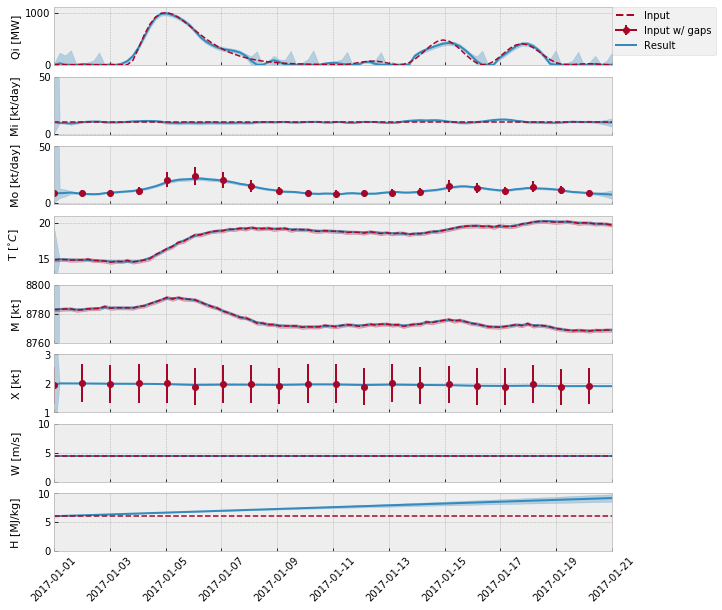

In [7]:
class TrellisPlot:
    def __init__(self):
        self.colors = None
        with plt.style.context('bmh'):
            prop_cycle = plt.rcParams['axes.prop_cycle']
            self.colors = prop_cycle.by_key()['color']
            
        self.lg_handles = []
        input_line = mlines.Line2D([], [], color=self.colors[1],
                                   label='Input', linestyle='--')
        self.lg_handles.append(input_line)
        input_w_gaps = plt.errorbar([0,1,2], [0,1,2], yerr=2,
                                    xerr=.01, color=self.colors[1],
                                    label='Input w/ gaps', marker='o')
        self.lg_handles.append(input_w_gaps)
        output_line = mlines.Line2D([], [], color=self.colors[0],
                                    label='Result')
        self.lg_handles.append(output_line)
        
        
    def get_traces(self, data, key):
        if key+'_err' in list(data.columns):
                # ignore warnings due to NaNs
                with np.errstate(invalid='ignore'):
                    ymean = data[key].values
                    ymean = np.where(ymean < 0., 0., ymean)
                    yerr = data[key+'_err'].values
                    ymin = ymean - 3*yerr
                    ymin = np.where(ymin < 0., 0., ymin)
                    ymax = ymean + 3*yerr
                    return [ymean, ymin, ymax]
        else:
            ymean = data[key].values
            with np.errstate(invalid='ignore'):
                ymean = np.where(ymean < 0., 0., ymean)
            return [ymean]

    def plot_trace(self, ax, data, key, ylim, ylabel,
                   labels=('Result', 'Input'),
                   alpha=.3, errorbar=False, ylabelsize=11):
        dates = data.index

        ymean, ymin, ymax = self.get_traces(data, key)
        line1 = ax.plot(dates, ymean, color=self.colors[0])
        ax.fill_between(dates, ymin, y2=ymax, 
                        alpha=alpha, color=self.colors[0])
        try:
            key1 = key.split('_uks')[0]
            traces = self.get_traces(data, key1)
            line2 = ax.plot(dates, traces[0], 
                            linestyle='--', linewidth=1.5,
                            color=self.colors[1])
            if len(traces) > 1:
                if errorbar:
                    err = (traces[1]/3.+traces[2]/3.)/2
                    line3 = ax.errorbar(dates, traces[0], yerr=err,
                                        label='Input w/ gaps',
                                        marker='o',
                                        color=self.colors[1])
                else:        
                    ax.fill_between(dates, traces[1], y2=traces[2],
                                    alpha=alpha, color=self.colors[1])
        except KeyError:
            pass
        ax.set_ylim(*ylim)
        ax.set_ylabel(ylabel, fontsize=ylabelsize)
        
with plt.style.context('bmh'):
    fig, axs = plt.subplots(nrows=8, ncols=1, figsize=(10,10), sharex=True,
                            gridspec_kw=dict(hspace=.2))
    tp = TrellisPlot()
    tp.plot_trace(axs[0], uks.data, 'qi_uks', (-10, 1100), 'Qi [MW]')
    tp.plot_trace(axs[1], uks.data, 'Mi_uks', (-1, 50), 'Mi [kt/day]')
    tp.plot_trace(axs[2], uks.data, 'Mo_uks', (-1, 50), 'Mo [kt/day]', errorbar=True)
    tp.plot_trace(axs[3], uks.data, 'T_uks', (13, 21), 'T [$^{\circ}C$]')
    tp.plot_trace(axs[4], uks.data, 'M_uks', (8760, 8800), 'M [kt]')
    tp.plot_trace(axs[5], uks.data, 'X_uks', (1., 3), 'X [kt]', errorbar=True)
    tp.plot_trace(axs[6], uks.data, 'W_uks', (0., 10), 'W [m/s]')
    tp.plot_trace(axs[7], uks.data, 'H_uks', (0., 10), 'H [MJ/kg]')
    axs[0].legend(handles=tp.lg_handles, loc=(1, .18))
    axs[0].set_xlim(uks.data.index[0], uks.data.index[-1])
    plt.xticks(rotation=45)
fig.align_ylabels()
fout = 'syn_example.png'
plt.savefig(fout, dpi=300, bbox_inches='tight')

In [9]:
xds.to_dataframe().to_csv('UKS_data.csv')

## Real data

In [10]:
ld = LakeData()
df_rd = ld.get_data_fits('2019-01-01', '2020-03-16', smoothing='dv')

In [11]:
ld.get_outflow()

In [12]:
ld.get_MetService_wind('/home/behrya/GeoNet/wind', default=None)

In [13]:
df_rd = ld.df
df_rd[~np.isnan(df_rd['Mo'])]

,T,T_err,z,z_err,Mg,Mg_err,X,X_err,v,v_err,...,a_err,p,p_err,M,M_err,dv,Mo,Mo_err,W,W_err
2019-02-26,33.792258,0.590247,2529.288167,0.002321,360.0,4.333333,3.190499,0.038623,8861.348019,0.452344,...,6.959310,0.991849,0.000195,8789.110998,1.789248,1.0,6.048,1.814400,2.314998,1.294656
2019-04-08,41.971538,0.306185,2529.239885,0.017374,NaN,NaN,NaN,NaN,8851.915844,3.392160,...,52.203071,0.989149,0.000101,8755.865842,3.478194,1.0,0.000,2.114715,6.276217,0.845318
2019-04-09,42.435000,0.244266,2529.235038,0.009767,NaN,NaN,NaN,NaN,8850.994279,1.899745,...,29.236583,0.988996,0.000081,8753.601569,2.003763,1.0,0.000,2.093019,3.472497,1.060553
2019-04-10,42.479259,0.295699,2529.216926,0.010247,NaN,NaN,NaN,NaN,8847.506055,2.003142,...,30.831032,0.988982,0.000098,8750.022334,2.158277,1.0,0.000,2.011931,5.273051,2.462713
2019-04-14,42.466000,0.298175,2529.223760,0.006747,NaN,NaN,NaN,NaN,8848.833594,1.316603,...,20.263487,0.988986,0.000098,8751.374913,1.566248,1.0,0.000,2.042527,4.244163,0.771666
2019-04-15,42.677083,0.301034,2529.206500,0.003217,NaN,NaN,NaN,NaN,8845.465330,0.622731,...,9.585243,0.988917,0.000099,8747.438751,1.069224,1.0,0.000,1.965255,4.629996,0.939242
2019-04-16,42.816538,0.299786,2529.189500,0.006641,NaN,NaN,NaN,NaN,8842.147986,1.292929,...,19.903104,0.988871,0.000099,8743.737302,1.551700,1.0,0.000,1.889148,4.244163,0.771666
2019-04-17,42.708333,0.884460,2529.179621,0.002145,375.5,6.500000,3.319611,0.057347,8840.242590,0.415748,...,6.400306,0.988906,0.000292,8742.167006,2.630575,1.0,0.000,1.844920,4.115552,0.727534
2019-04-18,43.310800,0.267051,2529.183480,0.002710,NaN,NaN,NaN,NaN,8840.998177,0.526977,...,8.112465,0.988707,0.000088,8741.166970,0.933491,1.0,0.000,1.862198,2.443609,0.647328
2019-04-19,43.601600,0.308635,2529.175520,0.005371,NaN,NaN,NaN,NaN,8839.450080,1.045909,...,16.101812,0.988611,0.000102,8738.786804,1.372535,1.0,0.000,1.826562,1.543332,0.939242


In [20]:
var_names = ['T', 'M', 'X', 'qi', 'Mi',
             'Mo', 'H', 'W', 'dqi',
             'dMi', 'dMo', 'dH', 'dW']
nvars = len(var_names)

X0 = xr.DataArray(np.ones(nvars)*np.nan, dims=('x'), coords={'x': var_names})
for k in var_names[:3]:
    X0.loc[k] = df_rd.iloc[0][k]
X0.loc['qi'] = 100
X0.loc['Mi'] = 10.
X0.loc['Mo'] = 10.
X0.loc['H'] = 3.
X0.loc['W'] = 4.5
X0.loc['dqi'] = 1e-1
X0.loc['dMi'] = 1e-1
X0.loc['dMo'] = 1e-1
X0.loc['dW'] = 0
X0.loc['dH'] = 0
X0.loc['qi'] *= 0.0864

Q = xr.DataArray(np.eye(nvars, nvars), dims=('x', 'y'),
                 coords={'x': var_names, 'y': var_names})
Q.loc['T','T'] = 1e-2
Q.loc['M','M'] = 1e0
Q.loc['X','X'] = 1e-3
Q.loc['qi','qi'] = 1e-10
Q.loc['Mi','Mi'] = 1
Q.loc['Mo','Mo'] = 1
Q.loc['W','W'] = 1e-10
Q.loc['H','H'] = 1e-5
Q.loc['dqi','dqi'] = 1e1
Q.loc['dMi','dMi'] = 1
Q.loc['dMo','dMo'] = 1
Q.loc['dW','dW'] = 1e-1
Q.loc['dH','dH'] = 1e-10

P0 = xr.DataArray(np.eye(nvars, nvars), dims=('x', 'y'),
                 coords={'x': var_names, 'y': var_names})
P0.loc['T','T'] = .1*X0.loc['T']
P0.loc['M','M'] = .1*X0.loc['M']
P0.loc['X','X'] = .1*X0.loc['X']
P0.loc['qi','qi'] = 100*0.0864
P0.loc['Mi','Mi'] = 1e2
P0.loc['Mo','Mo'] = 1e2
P0.loc['W','W'] = 1e-1
P0.loc['H','H'] = 1e-10
P0.loc['dqi','dqi'] = 1
P0.loc['dMi','dMi'] = 1
P0.loc['dMo','dMo'] = 1
P0.loc['dW','dW'] = 1e-10
P0.loc['dH','dH'] = 1e-10

In [21]:
uks = UnscentedKalmanSmoother(data=df_rd)
log_lh = uks(Q, X0, P0, test=True)
print(log_lh)

-3998.532265787784


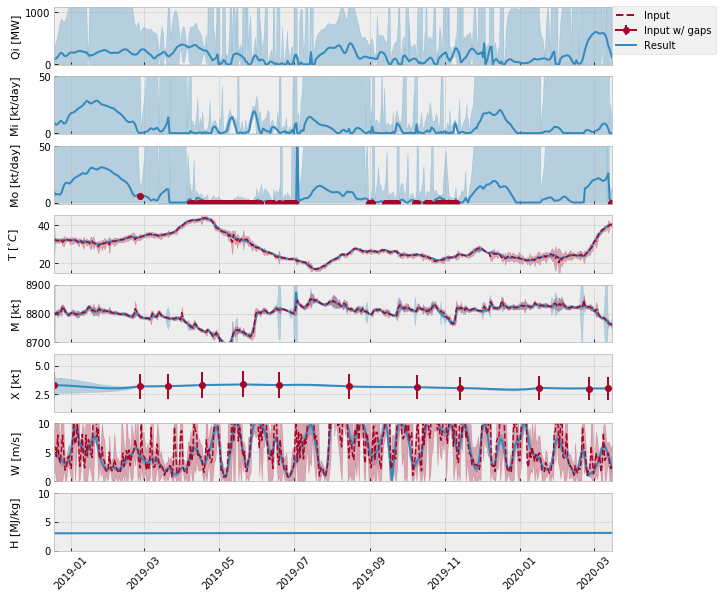

In [22]:
with plt.style.context('bmh'):
    fig, axs = plt.subplots(nrows=8, ncols=1, figsize=(10,10), sharex=True,
                            gridspec_kw=dict(hspace=.2))
    tp = TrellisPlot()
    tp.plot_trace(axs[0], uks.data, 'qi_uks', (-10, 1100), 'Qi [MW]')
    tp.plot_trace(axs[1], uks.data, 'Mi_uks', (-1, 50), 'Mi [kt/day]')
    tp.plot_trace(axs[2], uks.data, 'Mo_uks', (-1, 50), 'Mo [kt/day]', errorbar=True)
    tp.plot_trace(axs[3], uks.data, 'T_uks', (15, 45), 'T [$^{\circ}C$]')
    tp.plot_trace(axs[4], uks.data, 'M_uks', (8700, 8900), 'M [kt]')
    tp.plot_trace(axs[5], uks.data, 'X_uks', (1., 6.), 'X [kt]', errorbar=True)
    tp.plot_trace(axs[6], uks.data, 'W_uks', (0., 10), 'W [m/s]')
    tp.plot_trace(axs[7], uks.data, 'H_uks', (0., 10), 'H [MJ/kg]')
    axs[0].legend(handles=tp.lg_handles, loc=(1, .18))
    axs[0].set_xlim(uks.data.index[0], uks.data.index[-1])
    plt.xticks(rotation=45)
fig.align_ylabels()

### Goodness of fit (Battacharyya distance)

In [ ]:
def battacharyya_distance(m1, m2, var1, var2):
    return 0.25*np.log(0.25*(var1/var2 + var2/var1 + 2)) + 0.25*((m1 - m2)**2/(var1 + var2))

T_mean = data['T'][1:]
T_var = data['T_err'][1:]*data['T_err'][1:]
Tm = rs['model'].sel(obs='T')
Tm_mean = Tm.mean(axis=1)
Tm_var = Tm.var(axis=1)
D_B = battacharyya_distance(T_mean, Tm_mean, T_var, Tm_var)
plt.plot(D_B)

In [ ]:
M_mean = data['M'][1:]
M_var = data['M_err'][1:]*data['M_err'][1:]
Mm = rs['model'].sel(obs='M')
Mm_mean = Mm.mean(axis=1)
Mm_var = Mm.var(axis=1)
D_B = battacharyya_distance(M_mean, Mm_mean, M_var, Mm_var)
plt.plot(D_B)

In [ ]:
X_mean = data['X'][1:]
X_var = data['X_err'][1:]*data['X_err'][1:]
Xm = rs['model'].sel(obs='X')
Xm_mean = Xm.mean(axis=1)
Xm_var = Xm.var(axis=1)
D_B = battacharyya_distance(X_mean, Xm_mean, X_var, Xm_var)
plt.plot(D_B)

In [ ]:
rs['model']['dates']

In [ ]:
def mv_battacharyya_distance(m1, m2, var1, var2):
    dm = m1-m2
    dm2 = dm*dm
    dv = var1 + var2
    dv2 = 2./dv
    A = 0.125*np.diag(np.dot(dm2.T, dv2))

    dS=np.diag(np.dot((dv/2.).T,(dv/2.)))
    dS1 = np.diag(np.dot(var1.T,var1))
    dS2 = np.diag(np.dot(var2.T,var2))
    B = 0.5 * np.log(dS/np.sqrt(dS1*dS2))
    return A+B

u1 = np.vstack(((X_mean, M_mean), T_mean))
u2 = np.vstack(((Xm_mean, Mm_mean), Tm_mean))
var1 = np.vstack(((X_var, M_var), T_var))
var2 = np.vstack(((Xm_var, Mm_var), Tm_var))
mv_D_B = mv_battacharyya_distance(u1, u2, var1, var2)
plt.plot(rs['model']['dates'], mv_D_B)

In [ ]:
def gauss(m, v, x):
    return 1/np.sqrt(2.*np.pi*v)*np.exp(-0.5*(x-m)**2/v)

D_B = battacharyya_distance(T_mean, Tm_mean, T_var, Tm_var)
idxmx = np.argmax(D_B.values)
D_B_max = D_B.values.max()
idxmn = np.argmin(D_B.values)
D_B_min = D_B.values.min()
x = np.linspace(0,100,100000)
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
axs[0].plot(x, gauss(T_mean[idxmx], T_var[idxmx], x))
axs[0].plot(x, gauss(Tm_mean[idxmx].values, Tm_var[idxmx].values, x))
axs[0].set_xlim(28,31)
axs[0].text(.7, .7,'$D_B$ = %.3f'%D_B_max,
            fontsize=12, transform=axs[0].transAxes)
axs[0].set_xlabel('Temperature [$^{\circ}C$]')

axs[1].plot(x, gauss(T_mean[idxmn], T_var[idxmn], x))
axs[1].plot(x, gauss(Tm_mean[idxmn].values, Tm_var[idxmn].values, x))
axs[1].set_xlim(23,27)
axs[1].text(.7, .7,'$D_B$ = %.3f'%D_B_min,
            fontsize=12, transform=axs[1].transAxes)
axs[1].set_xlabel('Temperature [$^{\circ}C$]')
fig.savefig('DB_example.png', dpi=300, bbox_inches='tight')


In [ ]:
y = gauss(Tm_mean[idxmn].values, Tm_var[idxmn].values, x)
dx = np.diff(x)
dy = 0.5*(y[1:]+y[:-1])
np.sum(dx*dy)

In [ ]:
from obspy import read, UTCDateTime
dates = rs['dates'].data
t1 = UTCDateTime(pd.to_datetime(dates[0]))
t2 = UTCDateTime(pd.to_datetime(dates[-1]))
st = read('./2018.MAVZ.10-HHZ.NZ.bp_1.00-4.00.rsam')
st1 = st.trim(t1, t2)
tr = st1[0]

In [ ]:
url = "https://fits.geonet.org.nz/observation?"
url += "siteID=RU001&typeID=t&methodID={}"
names = ['t', 't_err']
# tdf1 = pd.read_csv(url.format('therm'),
#                    index_col=0, names=names, skiprows=1,
#                    parse_dates=True)
# tdf2 = pd.read_csv(url.format('thermcoup'),
#                    index_col=0, names=names, skiprows=1,
#                    parse_dates=True)
tdf = pd.read_csv(url.format('logic'),
                   index_col=0, names=names, skiprows=1,
                   parse_dates=True)
tdf = tdf[(tdf.index > '2018-01-01')&(tdf.index < '2018-12-12')]

In [ ]:
exp_q_in = rs['exp'].loc[:,'q_in']
var_q_in = rs['var'].loc[:,'q_in']
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
ax.plot(dates, exp_q_in, 'k')
ax.set_ylabel('Energy input rate [MW]')
ax1 = ax.twinx()
ax1.plot(tr.times('matplotlib'), tr.data, color='#1f77b4')
ax1.set_ylabel('RSAM', color='#1f77b4')
ax1.spines['right'].set_color('#1f77b4')
ax1.xaxis.label.set_color('#1f77b4')
ax1.tick_params(axis='y', colors='#1f77b4')
fout = os.path.join(plot_dir, 'comp_Q_rsam.png')
plt.savefig(fout, dpi=300, bbox_inches='tight')

In [ ]:
startdate = '2016-03-05'
enddate = '2019-04-23'
plot_dir = './'
c1 = clemb.Clemb(LakeDataFITS(), WindDataCSV(), start=startdate, end=enddate, h=2.8)

In [ ]:
from clemb import get_mg_data, get_ll, get_T
df_T = get_T(startdate, enddate)
df_T['t'].plot()

In [ ]:
df_ll = get_ll(startdate, enddate)

In [ ]:
df_ll['h'].plot()

In [ ]:
url = "https://fits.geonet.org.nz/observation?siteID={}&typeID=z"
names = ['h', 'h_err']
ldf = pd.read_csv(url.format('RU001'),
                  index_col=0, names=names, skiprows=1,
                  parse_dates=True)
ldf1 = pd.read_csv(url.format('RU001A'),
                   index_col=0, names=names, skiprows=1,
                   parse_dates=True)
ll_df = ldf.combine_first(ldf1)
ll_df.loc[ll_df.index < '1997-01-01', 'h'] = 2530. + \
    ll_df.loc[ll_df.index < '1997-01-01', 'h']
ll_df.loc[(ll_df.index > '1997-01-01') & (ll_df.index < '2012-12-31'), 'h'] = 2529.5 + \
          (ll_df.loc[(ll_df.index > '1997-01-01') & (ll_df.index < '2012-12-31'), 'h'] - 1.3)
ll_df.loc[ll_df.index > '2016-01-01', 'h'] = 2529.35 + (ll_df.loc[ll_df.index > '2016-01-01', 'h'] - 2.0)


In [ ]:
ll_df['h'].loc[ll_df.index > '2016-03-05'].plot()

In [ ]:
rs1 = c1.run_forward(nsamples=5000, m_out_prior='/home/yannik/workspace/crater_lake_temperature/src/clemb/notebook/outflow_prior.npz', new=False)

In [ ]:
days = mdates.DayLocator()  # every day
months = mdates.MonthLocator()
monthFmt = mdates.DateFormatter('%Y-%m-%d')
dayFmt = mdates.DateFormatter('%d')

datet = rs1['dates']
data = c1._df
t_data = data.index
nsteps = datet.size
nresample = 500

mpl.rcParams['figure.subplot.hspace'] = .9
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(18, 12))

axs[0,0].plot(np.ones(t_data.size)*4.5, ls='--')
adjust_labels(axs[0,0], t_data.values)
axs[0,0].set_xlim(0, data.shape[0])
axs[0,0].set_title('Wind speed [m/s]')

axs[0,1].plot(np.arange(data.shape[0]), data['X'], ls='--')
model_X = rs1['model'].sel(obs='X')
x_index = np.arange(model_X.shape[0])
axs[0,1].fill_between(np.arange(nsteps+1), data['X']-3*data['X_err'],
                       data['X']+3*data['X_err'], alpha=0.5)
axs[0,1].plot(x_index, model_X.mean(axis=1), 'k-')
axs[0,1].plot(x_index, model_X.mean(axis=1)+3*model_X.std(axis=1), 'k--')
axs[0,1].plot(x_index, model_X.mean(axis=1)-3*model_X.std(axis=1), 'k--')
adjust_labels(axs[0,1], datet.values)
axs[0,1].set_xlim(0, data.shape[0])
axs[0,1].set_title('Mg++ amount [kt]')

axs[1,0].plot(np.arange(data.shape[0]), data['T'], ls='--')
axs[1,0].fill_between(np.arange(data.shape[0]), data['T']-3*data['T_err'],
                      data['T']+3*data['T_err'], alpha=0.5)

model_T = rs1['model'].sel(obs='T')
axs[1,0].plot(x_index, model_T.mean(axis=1), 'k-')
axs[1,0].plot(x_index, model_T.mean(axis=1)+3*model_T.std(axis=1), 'k--')
axs[1,0].plot(x_index, model_T.mean(axis=1)-3*model_T.std(axis=1), 'k--')
adjust_labels(axs[1,0], datet.values)
axs[1,0].set_xlim(0, data.shape[0])
axs[1,0].set_title('Lake temperature [$^{\circ}C$]')

axs[1,1].plot(np.arange(data.shape[0]), data['M'], ls='--')
axs[1,1].fill_between(np.arange(data.shape[0]), data['M']-3*data['M_err'],
                      data['M']+3*data['M_err'], alpha=0.5)
model_M = rs1['model'].sel(obs='M')
axs[1,1].plot(x_index, model_M.mean(axis=1), 'k-')
axs[1,1].plot(x_index, model_M.mean(axis=1)+3*model_M.std(axis=1), 'k--')
axs[1,1].plot(x_index, model_M.mean(axis=1)-3*model_M.std(axis=1), 'k--')
adjust_labels(axs[1,1], datet.values)
axs[1,1].set_xlim(0, data.shape[0])
axs[1,1].set_title('Lake mass [kt]')

density_plot(axs[2,0], rs1, 'q_in', prm_lim=(0,1200,1000))
exp_q_in = rs1['exp'].loc[:,'q_in']
var_q_in = rs1['var'].loc[:,'q_in']
idx = np.argmax(rs1['lh'], axis=1)
map_q_in = rs1['q_in'][:, idx]
axs[2,0].plot(exp_q_in, 'k')
axs[2,0].plot(exp_q_in - 3*np.sqrt(var_q_in), 'k--')
axs[2,0].plot(exp_q_in + 3*np.sqrt(var_q_in), 'k--')
adjust_labels(axs[2,0], datet.data)
axs[2,0].set_ylim(0,1200)
axs[2,0].set_title('Heat input rate [MW]')

density_plot(axs[2,1], rs1, 'h', bw=0.01, prm_lim=(2.6,2.9,10))
exp_h = rs1['exp'].loc[:,'h']
axs[2,1].plot(exp_h, 'k')
adjust_labels(axs[2,1], datet.data)
axs[2,1].set_title('Enthalpy [TJ/kt]')

density_plot(axs[3,0], rs1, 'm_in', bw=1., prm_lim=(0,50,100))
exp_m_in = rs1['exp'].loc[:,'m_in']
var_m_in = rs1['var'].loc[:,'m_in']
axs[3,0].plot(exp_m_in, 'k')
axs[3,0].plot(exp_m_in - 3*np.sqrt(var_m_in), 'k--')
axs[3,0].plot(exp_m_in + 3*np.sqrt(var_m_in), 'k--')
adjust_labels(axs[3,0], datet.data)
axs[3,0].set_ylim(0, 50)
axs[3,0].set_title('Inflow [kt/day]')

density_plot(axs[3,1], rs1, 'm_out', bw=1., prm_lim=(0,50,100))
exp_m_out = rs1['exp'].loc[:,'m_out']
var_m_out = rs1['var'].loc[:,'m_out']
axs[3,1].plot(exp_m_out, 'k')
axs[3,1].plot(exp_m_out - 3*np.sqrt(var_m_out), 'k--')
axs[3,1].plot(exp_m_out + 3*np.sqrt(var_m_out), 'k--')
adjust_labels(axs[3,1], datet.data)
axs[3,1].set_ylim(0, 50)
axs[3,1].set_title('Outflow [kt/day]')

density_plot(axs[4,0], rs1, 'steam', bw=1., prm_lim=(0,30,100))
adjust_labels(axs[4,0], datet.data)
axs[4,0].set_ylim(0, 30)
axs[4,0].set_title('Steam input [kt/day]')
    

density_plot(axs[4,1], rs1, 'mevap', bw=0.5, prm_lim=(0,6,10))
adjust_labels(axs[4,1], datet.data)
axs[4,1].set_ylim(0, 6)
_ = axs[4,1].set_title('Evaporation mass loss [kt/day]')

if False:
    for row in range(5):
        for col in range(2):
            axs[row,col].xaxis.set_major_locator(months)
            axs[row,col].xaxis.set_major_formatter(monthFmt)
            axs[row,col].xaxis.set_minor_locator(days)
            #axs[row,col].set_xlim(datet[0].data, datet[-1].data)
#fout = os.path.join(plot_dir, 'clemb_inference_result_overview.png')
#fig.savefig(fout, dpi=300, bbox_inches='tight')

In [ ]:
from obspy import read, UTCDateTime, Stream
dates = rs1['dates'].data
t1 = UTCDateTime(pd.to_datetime(dates[0]))
t2 = UTCDateTime(pd.to_datetime(dates[-1]))
st = Stream()
for _fn in ['2016.MAVZ.10-HHZ.NZ.bp_1.00-4.00.rsam',
            '2017.MAVZ.10-HHZ.NZ.bp_1.00-4.00.rsam',
            '2018.MAVZ.10-HHZ.NZ.bp_1.00-4.00.rsam', 
            '2019.MAVZ.10-HHZ.NZ.bp_1.00-4.00.rsam']:
    st_tmp = read(_fn)
    tr = st_tmp[0]
    tr.stats.delta = 86400.0
    tr.stats.sampling_rate = 1./tr.stats.delta
    st += tr

st.merge(fill_value='interpolate')
st1 = st.trim(t1, t2)
tr_lt = st1[0]
# Get rid of the Kaikoura event
tr_lt.data = np.where(tr_lt.data < 600., tr_lt.data, 600.)

exp_q_in = rs1['exp'].loc[:,'q_in']
std_q_in = np.sqrt(rs1['var'].loc[:,'q_in'])
min_q = exp_q_in - std_q_in
max_q = exp_q_in + std_q_in
min_q = np.where(min_q < 0, 0., min_q)
fig = plt.figure(figsize=(20,6))
ax = fig.add_subplot(121)
ax.plot(dates, exp_q_in, 'k')
ax.fill_between(dates, min_q, max_q, color='k', alpha=0.2)
ax.tick_params(axis='x', labelrotation=30)
ax.set_ylabel('Energy input rate [MW]')
ax1 = ax.twinx()
ax1.plot(tr_lt.times('matplotlib'), tr_lt.data, color='#1f77b4')
ax1.set_ylabel('RSAM', color='#1f77b4')
ax1.spines['right'].set_color('#1f77b4')
ax1.xaxis.label.set_color('#1f77b4')
ax1.tick_params(axis='y', colors='#1f77b4')

ax2 = fig.add_subplot(122)
ax2.plot(dates, exp_q_in, 'k')
ax2.fill_between(dates, min_q, max_q, color='k', alpha=0.2)
ax2.tick_params(axis='x', labelrotation=30)
ax3 = ax2.twinx()
ax3.plot(data['T'].index, data['T'], color='#1f77b4')
ax3.set_ylabel('Temperature [$^{\circ}$C]', color='#1f77b4')
ax3.spines['right'].set_color('#1f77b4')
ax3.xaxis.label.set_color('#1f77b4')
ax3.tick_params(axis='y', colors='#1f77b4')

fout = os.path.join(plot_dir, 'long_term_comp_Q_rsam_T.png')
plt.savefig(fout, dpi=300, bbox_inches='tight')



In [ ]:
from scipy.stats.stats import rankdata
from scipy.stats import spearmanr
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20,8))
r1 = rankdata(tr_lt.data)
r2 = rankdata(exp_q_in)
r3 = rankdata(data['T'][1:])
cbar = axs[1].hexbin(r1, r2, gridsize=25, cmap='plasma')
axs[1].scatter(r1, r2, s=8, c='w')
#fig.colorbar(cbar, label='hexagon point density')
axs[1].set_xlabel('Tremor rank')
axs[1].set_ylabel('Heat input rate rank')

cbar = axs[0].hexbin(r1, r3, gridsize=25, cmap='plasma')
axs[0].scatter(r1, r3, s=8, c='w')
axs[0].set_xlabel('Tremor rank')
axs[0].set_ylabel('Temperature rank')
plt.savefig('Rank_correlation_tremor_temp_Q.png')
print('Rank correlation for tremor and heat input rate: ', spearmanr(tr_lt.data, exp_q_in))
print('Rank correlation for tremor and temperature: ', spearmanr(tr_lt.data, data['T'][1:]))

### Cumulative energy input

In [ ]:
from scipy.integrate import cumtrapz
import matplotlib.dates
plt.style.use('seaborn')
idx = dates >= np.datetime64('2018-01-01')
cum_q = cumtrapz(exp_q_in[idx], dx=0.0864)
cdates = dates[idx][1:]
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(cdates, cum_q)
ax.tick_params(axis='x', labelrotation=30)
ax1 = ax.twinx()
ax1.plot(cdates, exp_q_in[idx][1:], color='k')
ax1.set_ylabel('Energy input rate [MW]')
ax.xaxis.set_major_locator(
    matplotlib.dates.MonthLocator()
)
ax.xaxis.set_major_formatter(
    matplotlib.dates.DateFormatter('%Y-%m-%d')
)
ax.set_ylabel('Energy input [TJ]', color='#1f77b4')

## MCMC solutions

In [ ]:
xds1 = SynModel(seed=42).run(1000., nsteps=100, integration_method='euler', 
                    gradient=True, mode='gamma+sin', addnoise=False,
                    estimatenoise=False)

In [ ]:
df = xds1.to_dataframe()
cs = clemb.Clemb(None, None, None, None, pre_txt='syn1')
cs._df = df
cs._dates = df.index

In [ ]:
cs.drmg = True
cs.fullness = SynModel(area=df['a'].values).synth_fullness
rsb_cs = cs.run_backward(new=True)

In [ ]:
rs_cs = cs.run_forward(nsamples=1000, nresample=500, m_out_max=40., m_in_max=40., q_in_max=1500.,
                       intmethod='euler', new=True, tolH=3e30)

In [ ]:
fig = plt.figure(figsize=(10,3.1))
ax1 = fig.add_axes([0.01, 0.1, 0.8, 0.9])
ax2 = fig.add_axes([0.82, 0.1, 0.2, 0.9])
axs = [ax1, ax2]

exp_q_in = rs_cs['exp'].loc[:,'q_in']
density_plot(axs[0], rs_cs, 'q_in', mode='kde')
axs[0].plot(xds1['qi'], 'k-')
axs[0].plot(exp_q_in, 'k--')
ymin, ymax = axs[0].get_ylim()
ix1 = 20
ix2 = 65
axs[0].vlines(ix1, ymin, ymax, linestyle='--', color='white')
axs[0].vlines(ix2, ymin, ymax, linestyle='--', color='white')
adjust_labels(axs[0], rs_cs['dates'].data)
axs[0].set_ylabel('Energy input rate [MW]')
axs[0].set_xlim(0, exp_q_in.size)

def kde_plot(ax, data, label):
    idx = np.isnan(data)
    kde = KernelDensity(kernel='gaussian', bandwidth=60.).fit(data[~idx].reshape(-1,1))
    X_plot = np.linspace(0, 1600, 1000)[:, np.newaxis]
    log_dens = kde.score_samples(X_plot)
    Y = np.exp(log_dens)
    ax.plot(Y, X_plot[:, 0], label=label)

dates = rs_cs['dates'].data
dt = dates[ix1].astype('datetime64[us]')
label = pd.to_datetime(str(dt)).strftime("%d %b")
kde_plot(axs[1], rs_cs['q_in'][ix1].data, label=label)
dt = dates[ix2].astype('datetime64[us]')
label = pd.to_datetime(str(dt)).strftime("%d %b")
kde_plot(axs[1], rs_cs['q_in'][ix2].data, label=label)
axs[1].legend()
axs[1].yaxis.tick_right()
axs[1].set_xticks([])
axs[1].set_ylim(0, 1600)
fout = 'syn_example.png'
plt.savefig(fout, dpi=300, bbox_inches='tight')

In [ ]:
startdate = '2018-01-01'
tend = '2019-01-01'
plot_dir = './'
c = clemb.Clemb(LakeDataFITS(), WindDataCSV(), start=startdate, end=tend, h=2.8)

In [ ]:
c.drmg = True
rsb = c.run_backward()

In [ ]:
rs = c.run_forward(nsamples=5000, m_out_prior='/home/yannik/workspace/crater_lake_temperature/src/clemb/notebook/outflow_prior.npz', new=False)

In [ ]:
days = mdates.DayLocator()  # every day
months = mdates.MonthLocator()
monthFmt = mdates.DateFormatter('%Y-%m-%d')
dayFmt = mdates.DateFormatter('%d')

datet = rs['dates']
data = c._df
t_data = data.index
nsteps = datet.size
nresample = 500

mpl.rcParams['figure.subplot.hspace'] = .9
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(18, 12))

axs[0,0].plot(np.ones(t_data.size)*4.5, ls='--')
adjust_labels(axs[0,0], t_data.values)
axs[0,0].set_xlim(0, data.shape[0])
axs[0,0].set_title('Wind speed [m/s]')

axs[0,1].plot(np.arange(data.shape[0]), data['X'], ls='--')
model_X = rs['model'].sel(obs='X')
x_index = np.arange(model_X.shape[0])
axs[0,1].fill_between(np.arange(nsteps+1), data['X']-3*data['X_err'],
                       data['X']+3*data['X_err'], alpha=0.5)
axs[0,1].plot(x_index, model_X.mean(axis=1), 'k-')
axs[0,1].plot(x_index, model_X.mean(axis=1)+3*model_X.std(axis=1), 'k--')
axs[0,1].plot(x_index, model_X.mean(axis=1)-3*model_X.std(axis=1), 'k--')
adjust_labels(axs[0,1], datet.values)
axs[0,1].set_xlim(0, data.shape[0])
axs[0,1].set_title('Mg++ amount [kt]')

axs[1,0].plot(np.arange(data.shape[0]), data['T'], ls='--')
axs[1,0].fill_between(np.arange(data.shape[0]), data['T']-3*data['T_err'],
                      data['T']+3*data['T_err'], alpha=0.5)

model_T = rs['model'].sel(obs='T')
axs[1,0].plot(x_index, model_T.mean(axis=1), 'k-')
axs[1,0].plot(x_index, model_T.mean(axis=1)+3*model_T.std(axis=1), 'k--')
axs[1,0].plot(x_index, model_T.mean(axis=1)-3*model_T.std(axis=1), 'k--')
adjust_labels(axs[1,0], datet.values)
axs[1,0].set_xlim(0, data.shape[0])
axs[1,0].set_title('Lake temperature [$^{\circ}C$]')

axs[1,1].plot(np.arange(data.shape[0]), data['M'], ls='--')
axs[1,1].fill_between(np.arange(data.shape[0]), data['M']-3*data['M_err'],
                      data['M']+3*data['M_err'], alpha=0.5)
model_M = rs['model'].sel(obs='M')
axs[1,1].plot(x_index, model_M.mean(axis=1), 'k-')
axs[1,1].plot(x_index, model_M.mean(axis=1)+3*model_M.std(axis=1), 'k--')
axs[1,1].plot(x_index, model_M.mean(axis=1)-3*model_M.std(axis=1), 'k--')
adjust_labels(axs[1,1], datet.values)
axs[1,1].set_xlim(0, data.shape[0])
axs[1,1].set_title('Lake mass [kt]')

density_plot(axs[2,0], rs, 'q_in', prm_lim=(0,1200,1000))
exp_q_in = rs['exp'].loc[:,'q_in']
var_q_in = rs['var'].loc[:,'q_in']
idx = np.argmax(rs['lh'], axis=1)
map_q_in = rs['q_in'][:, idx]
axs[2,0].plot(exp_q_in, 'k')
axs[2,0].plot(exp_q_in - 3*np.sqrt(var_q_in), 'k--')
axs[2,0].plot(exp_q_in + 3*np.sqrt(var_q_in), 'k--')
axs[2,0].plot(rsb['pwr'], 'b-')
#axs[2,0].plot(map_q_in, 'g+')
adjust_labels(axs[2,0], datet.data)
axs[2,0].set_ylim(0,1200)
axs[2,0].set_title('Heat input rate [MW]')

density_plot(axs[2,1], rs, 'h', bw=0.01, prm_lim=(2.6,2.9,10))
exp_h = rs['exp'].loc[:,'h']
axs[2,1].plot(exp_h, 'k')
#axs[2,1].plot(np.arange(nsteps), exp[:,3] - 3*np.sqrt(var[:,3]), 'k--')
#axs[2,1].plot(np.arange(nsteps), exp[:,3] + 3*np.sqrt(var[:,3]), 'k--')
#axs[2,1].plot(np.arange(nsteps+1), np.ones(ndf.index.size)*6.0, ls='--')
adjust_labels(axs[2,1], datet.data)
axs[2,1].set_title('Enthalpy [TJ/kt]')

density_plot(axs[3,0], rs, 'm_in', bw=1., prm_lim=(0,50,100))
exp_m_in = rs['exp'].loc[:,'m_in']
var_m_in = rs['var'].loc[:,'m_in']
axs[3,0].plot(exp_m_in, 'k')
axs[3,0].plot(exp_m_in - 3*np.sqrt(var_m_in), 'k--')
axs[3,0].plot(exp_m_in + 3*np.sqrt(var_m_in), 'k--')
axs[3,0].plot(rsb['fmelt'], 'b-')
adjust_labels(axs[3,0], datet.data)
axs[3,0].set_ylim(0, 50)
axs[3,0].set_title('Inflow [kt/day]')

density_plot(axs[3,1], rs, 'm_out', bw=1., prm_lim=(0,50,100))
exp_m_out = rs['exp'].loc[:,'m_out']
var_m_out = rs['var'].loc[:,'m_out']
axs[3,1].plot(exp_m_out, 'k')
axs[3,1].plot(exp_m_out - 3*np.sqrt(var_m_out), 'k--')
axs[3,1].plot(exp_m_out + 3*np.sqrt(var_m_out), 'k--')
axs[3,1].plot(rsb['inf'], 'b-')
adjust_labels(axs[3,1], datet.data)
axs[3,1].set_ylim(0, 50)
axs[3,1].set_title('Outflow [kt/day]')

density_plot(axs[4,0], rs, 'steam', bw=1., prm_lim=(0,30,100))
axs[4,0].plot(rsb['steam'], 'b-')
adjust_labels(axs[4,0], datet.data)
axs[4,0].set_ylim(0, 30)
axs[4,0].set_title('Steam input [kt/day]')
    

density_plot(axs[4,1], rs, 'mevap', bw=0.5, prm_lim=(0,6,10))
axs[4,1].plot(rsb['evfl'], 'b-')
adjust_labels(axs[4,1], datet.data)
axs[4,1].set_ylim(0, 6)
_ = axs[4,1].set_title('Evaporation mass loss [kt/day]')

if False:
    for row in range(5):
        for col in range(2):
            axs[row,col].xaxis.set_major_locator(months)
            axs[row,col].xaxis.set_major_formatter(monthFmt)
            axs[row,col].xaxis.set_minor_locator(days)
            #axs[row,col].set_xlim(datet[0].data, datet[-1].data)
fout = os.path.join(plot_dir, 'clemb_inference_result_overview.png')
fig.savefig(fout, dpi=300, bbox_inches='tight')

In [ ]:
plt.style.use('seaborn')
labelsize=15
plt.rcParams.update({'xtick.major.size':4.0, 
                     'xtick.color':'k',
                     'axes.labelsize':20,
                     'xtick.labelsize':labelsize,
                     'ytick.labelsize':labelsize})

fig, axs = plt.subplots(nrows=5, ncols=1, figsize=(20, 18), gridspec_kw={'hspace':0.13})
to_plot = [True, True, True, True, True]

if to_plot[0]:
    density_plot(axs[0], rs, 'q_in', prm_lim=(0,1100,1000), mode='kde')
    axs[0].plot(rsb['pwr'], 'k')
    if False:
        exp_q_in = rs['exp'].loc[:,'q_in']
        var_q_in = rs['var'].loc[:,'q_in']
        axs[0].plot(exp_q_in, 'k')
        axs[0].plot(np.where(min_q_in>=0., min_q_in, 0.), 'k--')
        axs[0].plot(exp_q_in + np.sqrt(var_q_in), 'k--')
    adjust_labels(axs[0], rs['dates'].data)
    axs[0].set_xticklabels([])
    axs[0].set_ylabel('Energy input rate [MW]')
    axs[0].set_xlim(0, nsteps-1)
    axs[0].set_ylim(0, 1100)
    axs[0].text(0.02, 0.8, 'A', fontsize=14, bbox=dict(facecolor='#EAEAF2'),
                transform=axs[0].transAxes)

if to_plot[1]:
    density_plot(axs[1], rs, 'steam', prm_lim=(0,30,100), bw=1., mode='kde')
    ymin, ymax = axs[1].get_ylim()
    axs[1].set_ylim(0, ymax)
    adjust_labels(axs[1], rs['dates'].data)
    axs[1].set_xticklabels([])
    axs[1].set_ylabel('Steam input [kt/day]')
    axs[1].text(0.02, 0.8, 'B', fontsize=14, bbox=dict(facecolor='#EAEAF2'),
                transform=axs[1].transAxes)

if to_plot[2]:
    density_plot(axs[2], rs, 'm_in', prm_lim=(0,30,100), bw=1., mode='kde')
    adjust_labels(axs[2], rs['dates'].data)
    axs[2].set_xticklabels([])
    axs[2].set_ylabel('Inflow [kt/day]')
    axs[2].text(0.02, 0.8, 'C', fontsize=14, bbox=dict(facecolor='#EAEAF2'),
                transform=axs[2].transAxes)


if to_plot[3]:
    density_plot(axs[3], rs, 'm_out', prm_lim=(0,40,100), bw=2., mode='kde')
    adjust_labels(axs[3], rs['dates'].data)
    axs[3].set_xticklabels([])
    axs[3].set_ylabel('Outflow [kt/day]')
    axs[3].text(0.02, 0.8, 'D', fontsize=14, bbox=dict(facecolor='#EAEAF2'),
                transform=axs[3].transAxes)


if to_plot[4]:
    def mv_battacharyya_distance(m1, m2, var1, var2):
        dm = m1-m2
        dm2 = dm*dm
        dv = var1 + var2
        dv2 = 2./dv
        A = 0.125*np.diag(np.dot(dm2.T, dv2))

        dS=np.diag(np.dot((dv/2.).T,(dv/2.)))
        dS1 = np.diag(np.dot(var1.T,var1))
        dS2 = np.diag(np.dot(var2.T,var2))
        B = 0.5 * np.log(dS/np.sqrt(dS1*dS2))
        return A+B

    T_mean = data['T'][1:]
    T_var = data['T_err'][1:]*data['T_err'][1:]
    Tm = rs['model'].sel(obs='T')
    Tm_mean = Tm.mean(axis=1)
    Tm_var = Tm.var(axis=1)

    M_mean = data['M'][1:]
    M_var = data['M_err'][1:]*data['M_err'][1:]
    Mm = rs['model'].sel(obs='M')
    Mm_mean = Mm.mean(axis=1)
    Mm_var = Mm.var(axis=1)


    X_mean = data['X'][1:]
    X_var = data['X_err'][1:]*data['X_err'][1:]
    Xm = rs['model'].sel(obs='X')
    Xm_mean = Xm.mean(axis=1)
    Xm_var = Xm.var(axis=1)

    u1 = np.vstack(((X_mean, M_mean), T_mean))
    u2 = np.vstack(((Xm_mean, Mm_mean), Tm_mean))
    var1 = np.vstack(((X_var, M_var), T_var))
    var2 = np.vstack(((Xm_var, Mm_var), Tm_var))
    mv_D_B = mv_battacharyya_distance(u1, u2, var1, var2)

    axs[4].plot(mv_D_B)
    axs[4].set_xlim(0, nsteps-1)
    adjust_labels(axs[4], rs['dates'].data, fontsize=labelsize)
    axs[4].text(0.02, 0.8, 'E', fontsize=14,
                transform=axs[4].transAxes)
    axs[4].set_ylabel('$D_B$')

fout = os.path.join(plot_dir, 'clemb_inference_result.png')
plt.savefig(fout, dpi=300, bbox_inches='tight')